In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import LocallySparseNoise
from allen_v1dd.stimulus_analysis import analysis_tools as at
at.set_stylesheet()

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Check Jun's loading

In [9]:
jun_df = pd.read_csv("/Users/chase/Desktop/MindScope/jun_ss_analysis/dataframes/old/00220_roi_table_with_standard_roi_center.csv", index_col=0)
print(np.array(jun_df.columns))
jun_df.head()

['column_id' 'date' 'depth' 'dff_max' 'dff_min' 'dgcf_dff_dsi'
 'dgcf_dff_gdsi' 'dgcf_dff_gosi' 'dgcf_dff_osi' 'dgcf_dff_resp1'
 'dgcf_dff_resp1_std' 'dgcf_dff_resp2' 'dgcf_dff_resp2_std' 'dgcf_dff_sel'
 'dgcf_dff_spar' 'dgcf_eve_dsi' 'dgcf_eve_gdsi' 'dgcf_eve_gosi'
 'dgcf_eve_osi' 'dgcf_eve_resp1' 'dgcf_eve_resp1_std' 'dgcf_eve_resp2'
 'dgcf_eve_resp2_std' 'dgcf_eve_sel' 'dgcf_eve_spar' 'dgcw_center_alt'
 'dgcw_center_azi' 'dgcw_dff_dsi' 'dgcw_dff_gdsi' 'dgcw_dff_gosi'
 'dgcw_dff_osi' 'dgcw_dff_pref_dire' 'dgcw_dff_pref_sf' 'dgcw_dff_resp1'
 'dgcw_dff_resp1_std' 'dgcw_dff_resp2' 'dgcw_dff_resp2_std' 'dgcw_dff_sel'
 'dgcw_dff_spar' 'dgcw_eve_dsi' 'dgcw_eve_gdsi' 'dgcw_eve_gosi'
 'dgcw_eve_osi' 'dgcw_eve_pref_dire' 'dgcw_eve_pref_sf' 'dgcw_eve_resp1'
 'dgcw_eve_resp1_std' 'dgcw_eve_resp2' 'dgcw_eve_resp2_std' 'dgcw_eve_sel'
 'dgcw_eve_spar' 'is_unique_0.6' 'is_unique_0.8' 'is_unique_1.0'
 'is_unique_1.2' 'is_unique_1.4' 'is_valid' 'lims_id' 'mouse_id'
 'nan_in_dff' 'nan_in_event' 'ni118

,column_id,date,depth,dff_max,dff_min,dgcf_dff_dsi,dgcf_dff_gdsi,dgcf_dff_gosi,dgcf_dff_osi,dgcf_dff_resp1,...,skew_raw,spont_dff_mean,spont_dff_median,spont_dff_std,spont_eve_mean,spont_eve_median,spont_eve_std,ssi_dff,ssi_eve,volume_id
0,1,20181212,130,1.116302,-0.429458,0.021375,0.006519,0.009754,0.027348,0.005019,...,1.356856,0.006799,0.0,0.121311,0.000697,0.0,0.004725,0.171977,0.102832,1
1,1,20181212,130,2.766050,-0.476146,0.126940,0.013986,0.058958,0.180703,0.035794,...,2.980357,0.004632,0.0,0.129690,0.000511,0.0,0.003717,0.636578,0.559249,1
2,1,20181212,130,1.769444,-0.609623,0.039832,0.008637,0.017687,0.042644,0.081780,...,2.052450,0.007223,0.0,0.130330,0.000662,0.0,0.004585,0.862267,0.870140,1
3,1,20181212,130,4.928368,-0.494554,0.028176,0.007622,0.013891,0.036839,0.002953,...,7.078927,0.003600,0.0,0.108983,0.000463,0.0,0.003956,1.000000,0.445736,1
4,1,20181212,130,2.308394,-0.479238,0.105353,0.022852,0.030373,0.098666,0.013757,...,1.594139,0.006210,0.0,0.124400,0.000540,0.0,0.003909,-0.147307,-0.038156,1


In [113]:
client = OPhysClient("/Users/chase/Desktop/test_v1dd_data/")

In [114]:
for session_id in client.get_all_session_ids():
    if session_id.endswith("13"):
        print(session_id)

M409828_13
M416296_13
M427836_13
M438833_13


In [115]:
# Transformation

# (row, col), in pixels, column center before tranformation
COLUMN_CENTERS = {
    1: (0, 0),
    2: (-256, -256),
    3: (256, -256),
    4: (-256, 256),
    5: (256, 256)
}

COLUMN_COLORS = {
    1: 'r',
    2: 'g',
    3: 'b',
    4: 'm',
    5: 'k'
}

PIXEL_CENTER = 255.5 # Row and col go from 0 to 511 (inclusive), so the center is at 255.5
PIXEL_TO_MICRONS = 0.78125 # 400 microns / 512 pixels
TRANSFORM_MATRIX = scipy.spatial.transform.Rotation.from_euler("z", -40, degrees=True).as_matrix()[:2, :2] * PIXEL_TO_MICRONS

In [116]:
# session_ids = [session_id for session_id in client.get_all_session_ids() if session_id.startswith("M409828") and session_id.endswith("3")]
session_ids = [f"M409828_{c}3" for c in [1, 2, 3, 4, 5]]
pixels_by_column = {}

for session_id in tqdm(session_ids):
    session = client.load_ophys_session(session_id)
    column = session.get_column_id()
    pixels = [] # entries are (row, col)

    for plane in session.get_planes():
        for roi in session.get_rois(plane):
            if session.is_roi_valid(plane, roi):
                pixels.append(np.mean(np.where(session.get_roi_image_mask(plane, roi)), axis=1))

    pixels_by_column[column] = np.array(pixels)

  0%|          | 0/5 [00:00<?, ?it/s]

In [117]:
for column, pixels in pixels_by_column.items():
    print(f"M409828 Column {column}: {len(pixels)} ROIs in volume 3")

M409828 Column 1: 2708 ROIs in volume 3
M409828 Column 2: 2634 ROIs in volume 3
M409828 Column 3: 1447 ROIs in volume 3
M409828 Column 4: 2098 ROIs in volume 3
M409828 Column 5: 2733 ROIs in volume 3


In [118]:
def column_center_pixels(pixel_points, column):
    pixel_points = np.array(pixel_points)
    orig_shape = pixel_points.shape
    pixel_points = np.atleast_2d(pixel_points)
    bias = COLUMN_CENTERS[column]
    pixel_points[:, 0] = -(pixel_points[:, 0] - PIXEL_CENTER) + bias[0] # Note: the row is subtracted here
    # roi_row_col_centered[:, 0] = roi_row_col_centered[:, 0] - PIXEL_CENTER + bias[0] # Note: the row is subtracted here
    pixel_points[:, 1] = pixel_points[:, 1] - PIXEL_CENTER + bias[1]
    return pixel_points.reshape(orig_shape)

def transform_pixels_to_microns(pixel_points, column=None):
    if column is not None:
        pixel_points = column_center_pixels(pixel_points, column)
    
    return np.matmul(pixel_points, TRANSFORM_MATRIX)

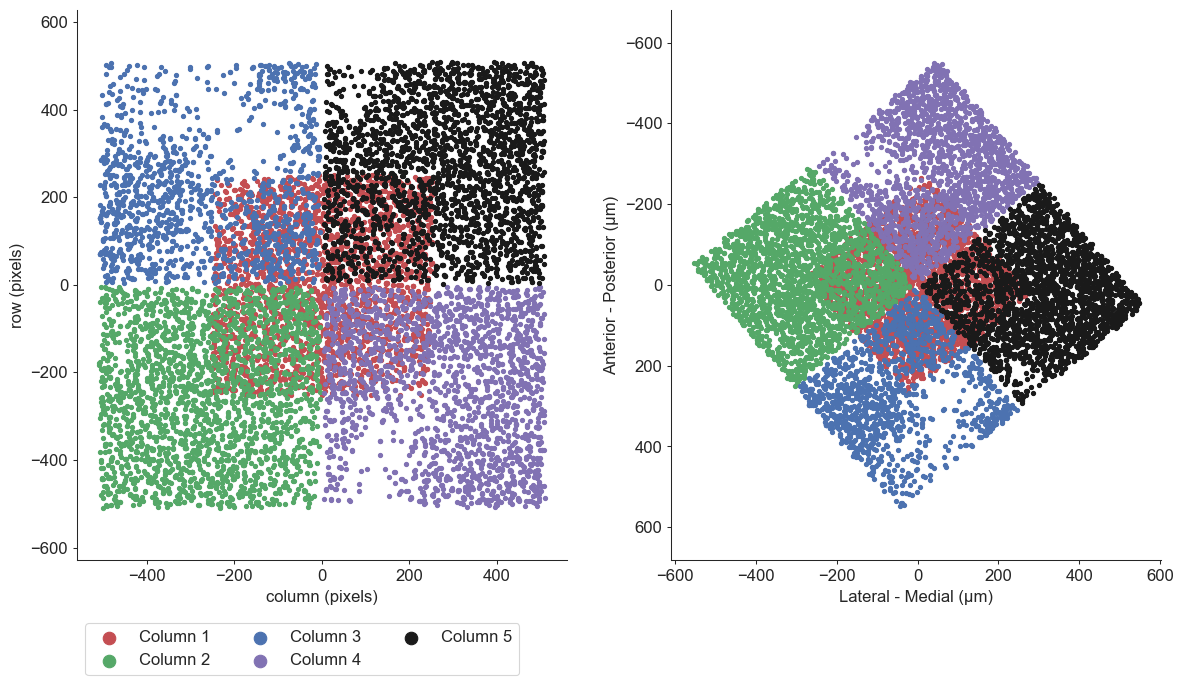

In [119]:
fig, axs = plt.subplots(figsize=(12, 7), ncols=2)

for column, pixels in pixels_by_column.items():
    pixels_centered = column_center_pixels(pixels, column)
    rois_microns = transform_pixels_to_microns(pixels_centered) # not passing a column just applies the transformation without recentering
    pixels_rows, pixels_columns = pixels_centered[:, 0], pixels_centered[:, 1]
    microns_ap, microns_lm = rois_microns[:, 0], rois_microns[:, 1]
    s = 9

    axs[0].scatter(pixels_columns, pixels_rows, s=s, color=COLUMN_COLORS[column], label=f"Column {column}")
    axs[1].scatter(microns_lm, microns_ap, s=s, color=COLUMN_COLORS[column], label=f"Column {column}")

axs[0].axis("equal")
axs[0].set_xlabel("column (pixels)")
axs[0].set_ylabel("row (pixels)")
axs[0].legend(ncols=3, markerscale=3, loc="upper left", bbox_to_anchor=(0, -0.1), bbox_transform=axs[0].transAxes)
axs[0].axis("equal")

# axs[0].add_patch(plt.Rectangle((-512, 0), 512, 512, alpha=0.25))

axs[1].set_xlabel("Lateral - Medial (µm)")
axs[1].invert_yaxis()
axs[1].set_ylabel("Anterior - Posterior (µm)")
axs[1].axis("equal")

fig.tight_layout()

# Overlay retinotopy

In [5]:
import h5py

def get_h5_group(h5_file, group_names, create_if_not_exists=True, overwrite=False):
    curr_group = h5_file

    for i in range(len(group_names)):
        name = group_names[i]
        is_last = i == len(group_names) - 1
        
        if is_last and name in curr_group and overwrite:
            del curr_group[name]

        if name in curr_group:
            curr_group = curr_group[name]
        else:
            if create_if_not_exists:
                curr_group = curr_group.create_group(name)
            else:
                return None

    return curr_group

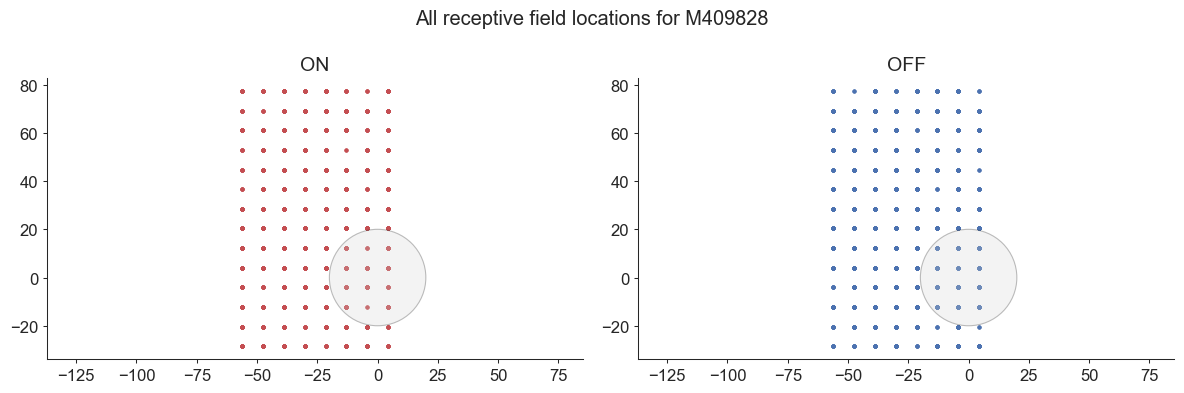

In [122]:
# Plot all RF locations
fig, axs = plt.subplots(figsize=(12, 4), ncols=2)

with h5py.File("../../data_frames/lsn-events.h5", "r") as f:
    # for mouse_id in f.keys():
    mouse_id = "M409828"
    for cv_key in f[mouse_id].keys():
        for plane_key in f[mouse_id][cv_key].keys():
            group = f[mouse_id][cv_key][plane_key]

            # 0 = on, 1 = off
            on_rf_center = group["rf_centers"][group["is_responsive"][:, 0], 0]
            off_rf_center = group["rf_centers"][group["is_responsive"][:, 1], 1]
            
            axs[0].scatter(on_rf_center[:, 0], on_rf_center[:, 1], s=5, color="r")
            axs[1].scatter(off_rf_center[:, 0], off_rf_center[:, 1], s=5, color="b")

axs[0].set_title("ON")
axs[1].set_title("OFF")
for ax in axs:
    ax.axis("equal")
    ax.add_patch(plt.Circle((0, 0), 20, edgecolor="black", facecolor="lightgray", alpha=0.25))

fig.suptitle("All receptive field locations for M409828")
fig.tight_layout()

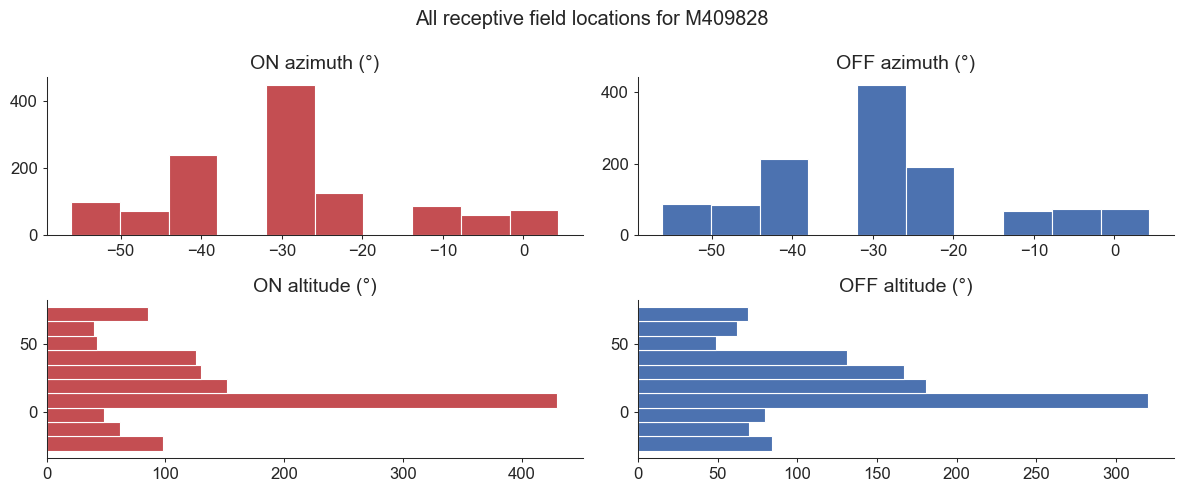

In [123]:
# Distributions of altitudes and azimuths
# Plot all RF locations
fig, axs = plt.subplots(figsize=(12, 5), nrows=2, ncols=2)

on_azi = []
on_alt = []
off_azi = []
off_alt = []

with h5py.File("../../data_frames/lsn-events.h5", "r") as f:
    # for mouse_id in f.keys():
    mouse_id = "M409828"
    for cv_key in f[mouse_id].keys():
        if cv_key[0] != "1": continue
        for plane_key in f[mouse_id][cv_key].keys():
            group = f[mouse_id][cv_key][plane_key]

            # 0 = on, 1 = off
            on_rf_center = group["rf_centers"][group["is_responsive"][:, 0], 0]
            off_rf_center = group["rf_centers"][group["is_responsive"][:, 1], 1]
            
            on_azi = np.concatenate((on_azi, on_rf_center[:, 0]))
            on_alt = np.concatenate((on_alt, on_rf_center[:, 1]))
            off_azi = np.concatenate((off_azi, off_rf_center[:, 0]))
            off_alt = np.concatenate((off_alt, off_rf_center[:, 1]))

axs[0, 0].set_title("ON azimuth (°)")
axs[0, 0].hist(on_azi, color="r")

axs[1, 0].set_title("ON altitude (°)")
axs[1, 0].hist(on_alt, color="r", orientation="horizontal")

axs[0, 1].set_title("OFF azimuth (°)")
axs[0, 1].hist(off_azi, color="b")

axs[1, 1].set_title("OFF altitude (°)")
axs[1, 1].hist(off_alt, color="b", orientation="horizontal")

fig.suptitle("All receptive field locations for M409828")
fig.tight_layout()

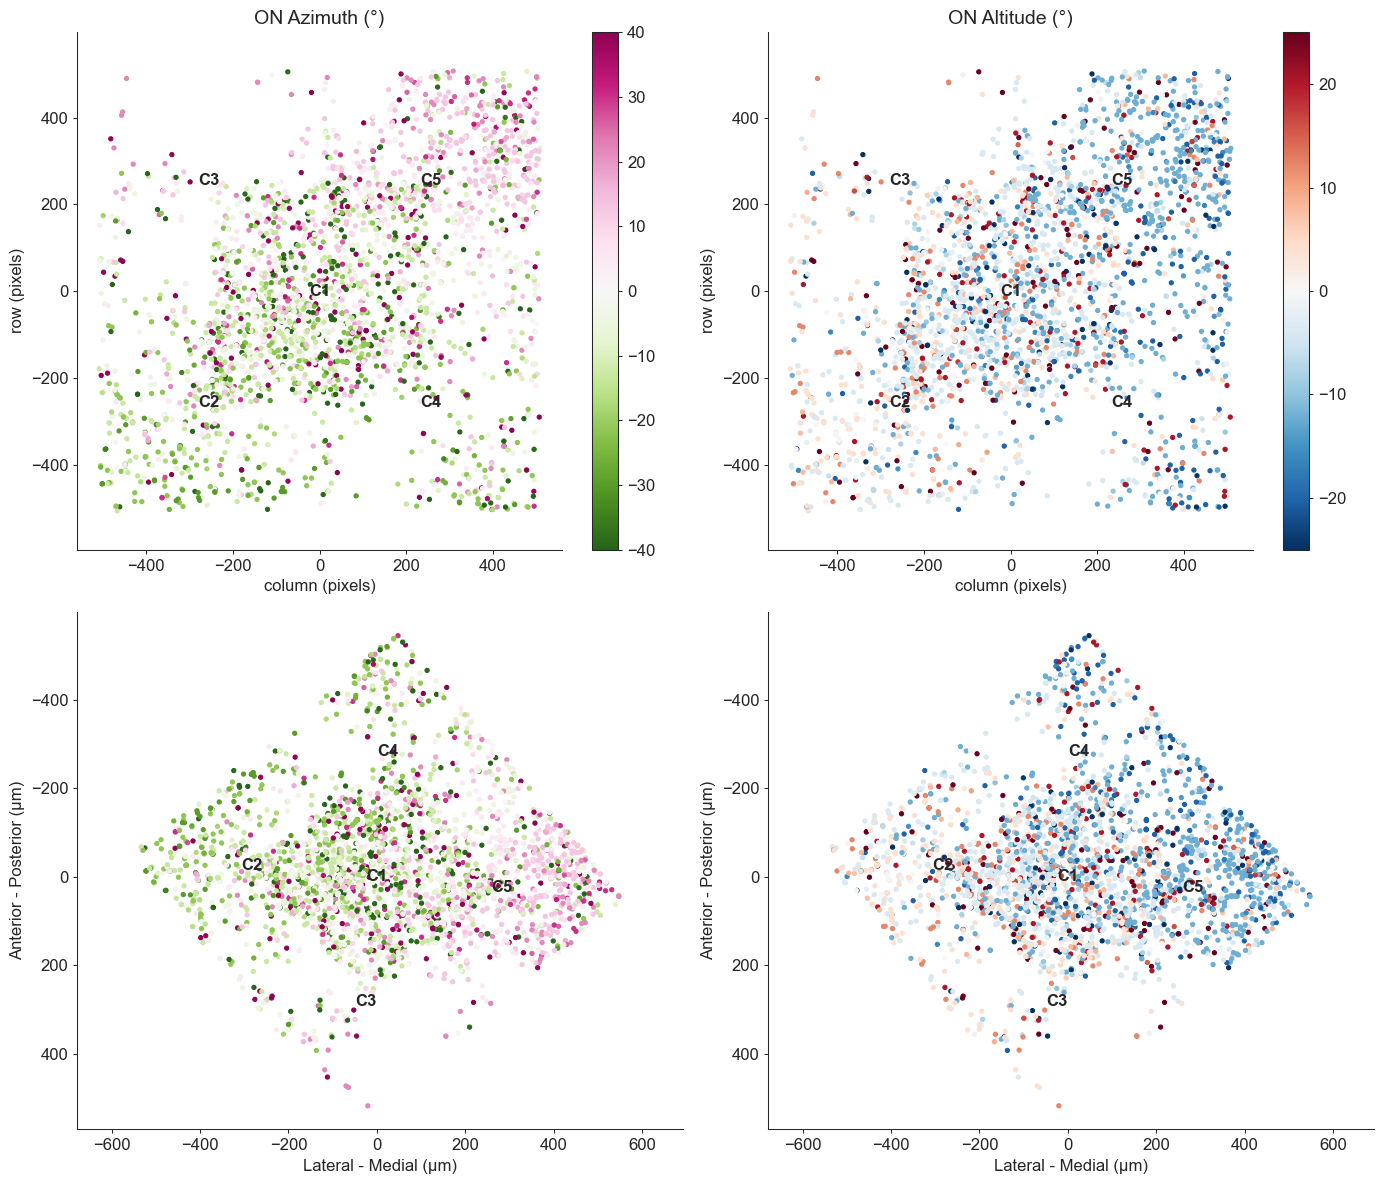

In [125]:
fig, axs = plt.subplots(figsize=(14, 12), nrows=2, ncols=2)

rf_type, rf_type_idx = "ON", 0
# rf_type, rf_type_idx = "OFF", 1

with h5py.File("../../data_frames/lsn-events.h5", "r") as f:
    for mouse_id in ["M409828"]:
    # for mouse_id in f.keys():
        for cv_key in f[mouse_id].keys():
            for plane_key in f[mouse_id][cv_key].keys():
                group = f[mouse_id][cv_key][plane_key]
                has_rf = group["is_responsive"][:, rf_type_idx]
                if not has_rf.any(): continue
                on_rf_center = group["rf_centers"][has_rf, rf_type_idx]

                pixel_points = group["roi_centroids"][has_rf, :]
                column = int(cv_key[0])
                centered_pixel_points = column_center_pixels(pixel_points, column)
                transformed_pixel_points = transform_pixels_to_microns(centered_pixel_points)
                
                
                # Azimuth
                r = 40
                # cmap = "jet"
                cmap = "PiYG_r"
                sc00 = axs[0, 0].scatter(centered_pixel_points[:, 1], centered_pixel_points[:, 0], s=9, c=on_rf_center[:, 0], cmap=cmap, vmin=-r, vmax=r)
                sc10 = axs[1, 0].scatter(transformed_pixel_points[:, 1], transformed_pixel_points[:, 0], s=9, c=on_rf_center[:, 0], cmap=cmap, vmin=-r, vmax=r)

                # Altitude
                r = 25
                cmap = "RdBu_r"
                sc01 = axs[0, 1].scatter(centered_pixel_points[:, 1], centered_pixel_points[:, 0], s=9, c=on_rf_center[:, 1], cmap=cmap, vmin=-r, vmax=r)
                sc11 = axs[1, 1].scatter(transformed_pixel_points[:, 1], transformed_pixel_points[:, 0], s=9, c=on_rf_center[:, 1], cmap=cmap, vmin=-r, vmax=r)


fig.colorbar(sc00, ax=axs[0, 0])
fig.colorbar(sc01, ax=axs[0, 1])

# for column, pixels in pixels_by_column.items():
#     pixels_centered = column_center_pixels(pixels, column)
#     rois_microns = transform_pixels_to_microns(pixels_centered) # not passing a column just applies the transformation without recentering
#     pixels_rows, pixels_columns = pixels_centered[:, 0], pixels_centered[:, 1]
#     microns_ap, microns_lm = rois_microns[:, 0], rois_microns[:, 1]
#     s = 9

#     axs[0].scatter(pixels_columns, pixels_rows, s=s, color=COLUMN_COLORS[column], label=f"Column {column}")
#     axs[1].scatter(microns_lm, microns_ap, s=s, color=COLUMN_COLORS[column], label=f"Column {column}")

axs[0, 0].set_title(f"{rf_type} Azimuth (°)")
axs[0, 1].set_title(f"{rf_type} Altitude (°)")

for column, (row, col) in COLUMN_CENTERS.items():
    y, x = transform_pixels_to_microns([row, col])

    for i in range(2):
        axs[0, i].text(x=col, y=row, s=f"C{column}", fontweight="bold", ha="center", va="center")
        axs[1, i].text(x=x, y=y, s=f"C{column}", fontweight="bold", ha="center", va="center")
    

for ax in axs[0, :]:
    ax.set_xlabel("column (pixels)")
    ax.set_ylabel("row (pixels)")
    ax.axis("equal")

# # axs[0].add_patch(plt.Rectangle((-512, 0), 512, 512, alpha=0.25))
for ax in axs[1, :]:
    ax.invert_yaxis()
    ax.set_xlabel("Lateral - Medial (µm)")
    ax.set_ylabel("Anterior - Posterior (µm)")
    ax.axis("equal")

fig.tight_layout()

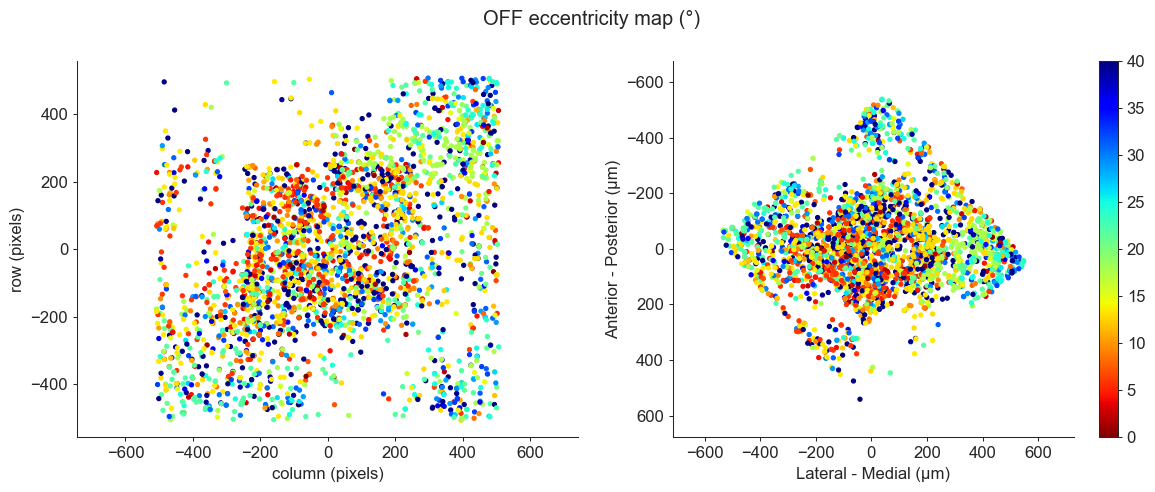

In [139]:
fig, axs = plt.subplots(figsize=(12, 5), ncols=2)

rf_type, rf_type_idx = "ON", 0
rf_type, rf_type_idx = "OFF", 1

with h5py.File("../../data_frames/lsn-events.h5", "r") as f:
    for mouse_id in ["M409828"]:
    # for mouse_id in f.keys():
        for cv_key in f[mouse_id].keys():
            for plane_key in f[mouse_id][cv_key].keys():
                group = f[mouse_id][cv_key][plane_key]
                has_rf = group["is_responsive"][:, rf_type_idx]
                if not has_rf.any(): continue
                rf_center = group["rf_centers"][has_rf, rf_type_idx]

                pixel_points = group["roi_centroids"][has_rf, :]
                column = int(cv_key[0])
                centered_pixel_points = column_center_pixels(pixel_points, column)
                transformed_pixel_points = transform_pixels_to_microns(centered_pixel_points)
                
                eccentricity = np.sqrt(rf_center[:, 0]**2 + rf_center[:, 1]**2)

                # Azimuth
                r = 40
                cmap = "jet_r"
                # cmap = "PiYG_r"
                sc0 = axs[0].scatter(centered_pixel_points[:, 1], centered_pixel_points[:, 0], s=9, c=eccentricity, cmap=cmap, vmin=0, vmax=r)
                sc1 = axs[1].scatter(transformed_pixel_points[:, 1], transformed_pixel_points[:, 0], s=9, c=eccentricity, cmap=cmap, vmin=0, vmax=r)


# fig.colorbar(sc00, ax=axs[0, 0])
fig.colorbar(sc1, ax=axs[1])

# for column, pixels in pixels_by_column.items():
#     pixels_centered = column_center_pixels(pixels, column)
#     rois_microns = transform_pixels_to_microns(pixels_centered) # not passing a column just applies the transformation without recentering
#     pixels_rows, pixels_columns = pixels_centered[:, 0], pixels_centered[:, 1]
#     microns_ap, microns_lm = rois_microns[:, 0], rois_microns[:, 1]
#     s = 9

#     axs[0].scatter(pixels_columns, pixels_rows, s=s, color=COLUMN_COLORS[column], label=f"Column {column}")
#     axs[1].scatter(microns_lm, microns_ap, s=s, color=COLUMN_COLORS[column], label=f"Column {column}")

# for column, (row, col) in COLUMN_CENTERS.items():
#     y, x = transform_pixels_to_microns([row, col])

#     for i in range(2):
#         axs[0, i].text(x=col, y=row, s=f"C{column}", fontweight="bold", ha="center", va="center")
#         axs[1, i].text(x=x, y=y, s=f"C{column}", fontweight="bold", ha="center", va="center")
    

axs[0].set_xlabel("column (pixels)")
axs[0].set_ylabel("row (pixels)")
axs[0].axis("equal")

axs[1].invert_yaxis()
axs[1].set_xlabel("Lateral - Medial (µm)")
axs[1].set_ylabel("Anterior - Posterior (µm)")
axs[1].axis("equal")

fig.suptitle(f"{rf_type} eccentricity map (°)")
fig.tight_layout()